# SIR model
$$\frac{S}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I.$$

- train and show on [0,60]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import autograd.numpy as np # Autograd library allows for automatic differentiation of functions written in Python
from autograd import elementwise_grad as egrad

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

In [2]:
# Define the neural network model for each ODE
class PINN_1layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer, self).__init__()
        self.initial_value = initial_value
        self.initial_point_of_the_domain = initial_point_of_the_domain
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))
        x_ = self.layer2(x_)
        x_ = self.initial_value + (x - self.initial_point_of_the_domain) * x_
        return x_

In [3]:
# Define the ODE functions
def ode_function1(S, I):
    return -beta*I*S

In [4]:
def ode_function2(S, I):
    return beta*I*S - gamma*I

In [5]:
def ode_function3(S, I):
    return gamma*I

In [6]:
# Define the loss function for the PINN
def pinn_loss(model1, model2, model3, x_collocation, ode_function, eq):
    
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)
    
    u_pred_collocation_1 = model1(x_collocation_tensor)
    u_pred_collocation_2 = model2(x_collocation_tensor)
    u_pred_collocation_3 = model3(x_collocation_tensor)
    
    if eq == '1':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_1, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_1), 
                                                create_graph=True)[0]
        loss_collocation = torch.mean((u_pred_derivative - 
                                   ode_function(u_pred_collocation_1, u_pred_collocation_2)) ** 2)
        
    elif eq == '2':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_2, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_2), 
                                                create_graph=True)[0]
        loss_collocation = torch.mean((u_pred_derivative - 
                                   ode_function(u_pred_collocation_1, u_pred_collocation_2)) ** 2)
    elif eq == '3':
        u_pred_derivative = torch.autograd.grad(u_pred_collocation_3, x_collocation_tensor,
                                                grad_outputs=torch.ones_like(u_pred_collocation_3), 
                                                create_graph=True)[0]
        loss_collocation = torch.mean((u_pred_derivative - 
                                   ode_function(u_pred_collocation_1, u_pred_collocation_2)) ** 2)
    else:
        return 

    total_loss = loss_collocation
    return total_loss

In [7]:
# Parameters

initial_S = 990  # Initial number of susceptible individuals
initial_I = 20  # Initial number of infectious individuals
initial_R = 0 # Initial number of recovered individuals
N = initial_S + initial_I + initial_R # Total population size

beta = 0.001  # Rate of infection
gamma = 0.1  # Rate of recovery

In [8]:
# Define the parameters
input_size = 1
hidden_size = 60
output_size = 1

initial_value_1 = initial_S
initial_value_2 = initial_I
initial_value_3 = initial_R

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 60
number_of_time_steps = 1000

# Create instances of the PINN models
model1 = PINN_1layer(input_size, hidden_size, output_size, initial_value_1, initial_point_of_the_domain)
model2 = PINN_1layer(input_size, hidden_size, output_size, initial_value_2, initial_point_of_the_domain)
model3 = PINN_1layer(input_size, hidden_size, output_size, initial_value_3, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

# Define the optimizer for each model
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

# Training loop for both models
num_epochs = 3000
for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()

    loss1 = pinn_loss(model1, model2, model3, x_collocation, ode_function1, '1')
    loss2 = pinn_loss(model1, model2, model3, x_collocation, ode_function2, '2')
    loss3 = pinn_loss(model1, model2, model3, x_collocation, ode_function3, '3')

    total_loss = loss1 + loss2 + loss3

    total_loss.backward()

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

# Evaluate the trained models
with torch.no_grad():
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    u_pred_tensor1 = model1(x_test_tensor)
    u_pred_tensor2 = model2(x_test_tensor)
    u_pred_tensor3 = model3(x_test_tensor)

    u_pred1 = u_pred_tensor1.numpy()
    u_pred2 = u_pred_tensor2.numpy()
    u_pred3 = u_pred_tensor3.numpy()

In [9]:
# RK4 
# Function defining the SIS model equations
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * S
    dIdt = beta * I * S - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

t_span = (0, 60)  # Time span for integration
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Initial conditions
y0 = [initial_S, initial_I, initial_R]

# Solve the ODEs
sol = solve_ivp(SIR_model, t_span, y0, args=(beta, gamma), dense_output=True)

y_eval = sol.sol(t_eval)

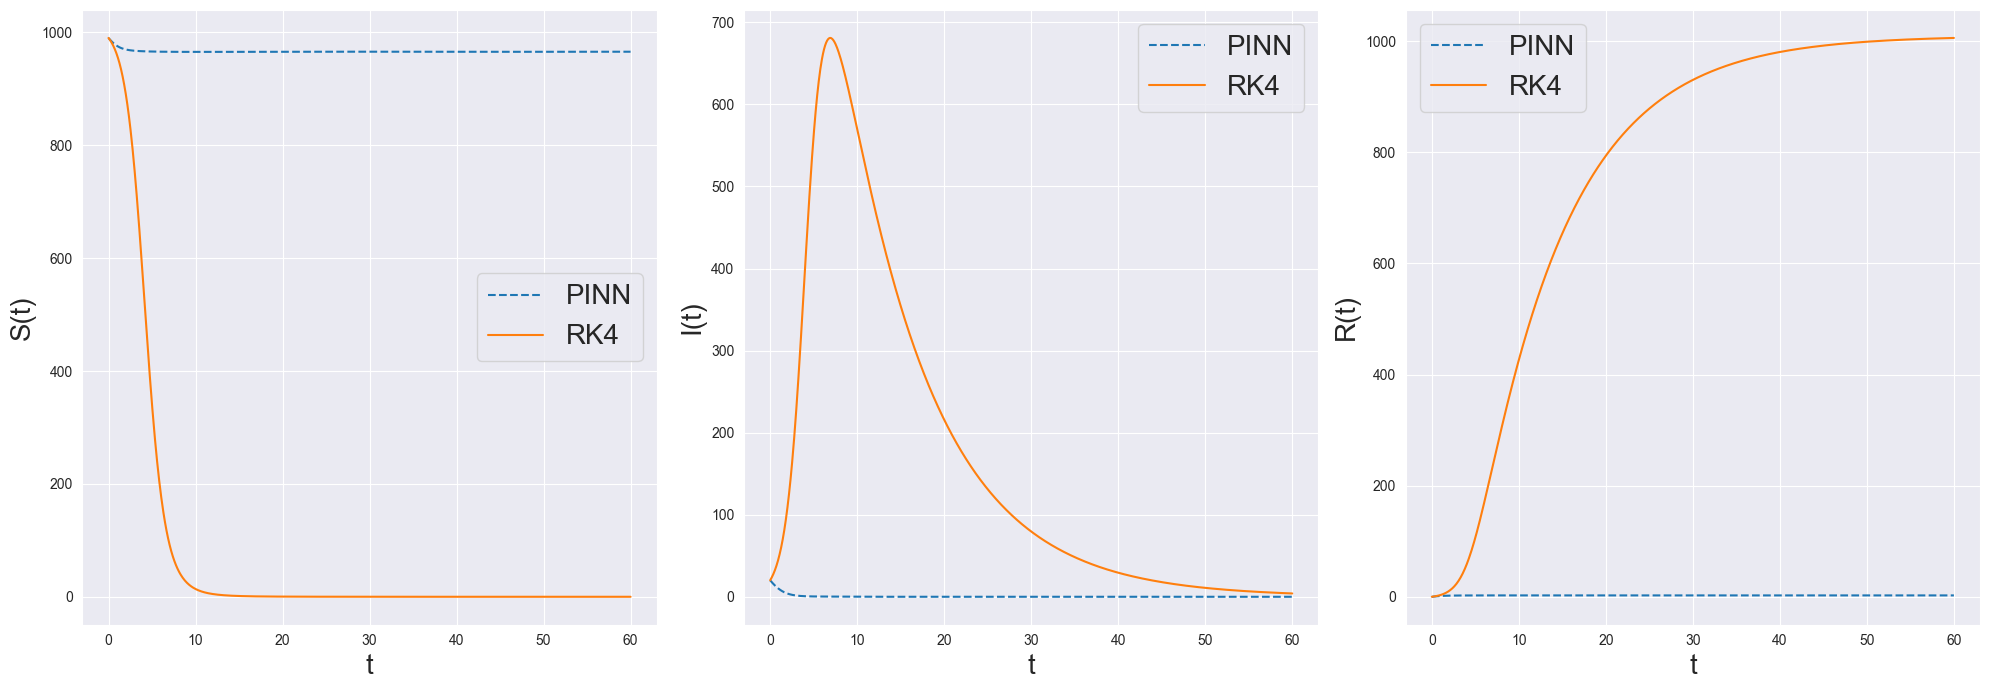

In [23]:
# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_pred1, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval[0], label='RK4')
plt.xlabel('t', fontsize=20)
plt.ylabel('S(t)', fontsize=20)
#plt.title('Comparison of solutions of S trajectory from SIR model', fontsize=17)
plt.legend(fontsize=20)

plt.subplot(1, 3, 2)
plt.plot(x_test, u_pred2, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval[1], label='RK4')
plt.xlabel('t', fontsize=20)
plt.ylabel('I(t)', fontsize=20)
#plt.title('Comparison of solutions of I trajectory from SIR model', fontsize=17)
plt.legend(fontsize=20)

plt.subplot(1, 3, 3)
plt.plot(x_test, u_pred3, label='PINN', linestyle='--')
plt.plot(t_eval, y_eval[2], label='RK4')
plt.xlabel('t', fontsize=20)
plt.ylabel('R(t)', fontsize=20)
#plt.title('Comparison of solutions of R trajectory from SIR model', fontsize=17)
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()
#fig.savefig('graphs/PINN_SIR_solution.pdf')